In [25]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
from collections import Counter
from tqdm import tqdm
import spateo as st
import seaborn as sns
import pandas as pd
import scanpy as sc
from scipy import spatial

def adjusted_rand_score(y_true, y_pred):
    (tn, fp), (fn, tp) = metrics.pair_confusion_matrix(y_true, y_pred)
    tn, tp, fp, fn =int(tn), int(tp), int(fp), int(fn)
    if fn == 0 and fp == 0:
        return 1.0
    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

def compute_stats(y_true, y_pred):
    y_true_bool = y_true > 0
    y_pred_bool = y_pred > 0
    pos = y_true_bool.sum()
    neg = (~y_true_bool).sum()
    
    y_true_bool_flattened = y_true_bool.flatten()
    y_pred_bool_flattened = y_pred_bool.flatten()
    tn, fp, fn, tp = metrics.confusion_matrix(y_true_bool_flattened, y_pred_bool_flattened).ravel()
    f1 = metrics.f1_score(y_true_bool_flattened, y_pred_bool_flattened)
    
    where = (y_true > 0) & (y_pred > 0)
    y_true_labels = y_true[where]
    y_pred_labels = y_pred[where]
    ars = adjusted_rand_score(y_true_labels, y_pred_labels)
    homogeneity, completeness, v = metrics.homogeneity_completeness_v_measure(y_true_labels, y_pred_labels)
    
    return tn / neg, fp / neg, fn / pos, tp / pos, f1, ars, homogeneity, completeness, v

## Load data

In [4]:
seg_adata = anndata.read('data/E16.5_E1S3.h5ad')
cell_adata = anndata.read('data/adata_E16.5_E1S3_cell_labels.h5ad')
X_adata = anndata.read('data/adata_E16.5_E1S3_X_labels.h5ad')
random_adata = anndata.read('data/adata_E16.5_E1S3_random_X_labels.h5ad')

## Pixel classification statistics

Consider the segmentation problem as a pixel classification problem.

### Nuclei labels

In [3]:
stain_labels = seg_adata.layers['stain_labels'][seg_adata.X.A > 0]
unspliced_labels = seg_adata.layers['unspliced_labels'][seg_adata.X.A > 0]
compute_stats(stain_labels, unspliced_labels)

(0.9530779427800053,
 0.04692205721999464,
 0.8652490396393218,
 0.13475096036067827,
 0.22125824330828509,
 0.8037711567220533,
 0.966656724918882,
 0.9882066965219727,
 0.9773129297173658)

### Cell labels

In [4]:
cell_labels = seg_adata.layers['cell_labels_expanded'][seg_adata.X.A > 0]
X_labels = seg_adata.layers['X_labels_expanded'][seg_adata.X.A > 0]
compute_stats(cell_labels, X_labels)

(0.9775129896815707,
 0.022487010318429215,
 0.7900760796851005,
 0.20992392031489945,
 0.34512184281689157,
 0.6417269830826187,
 0.9330560684380664,
 0.9752772974599759,
 0.9536996177569598)

Compare these to randomly permuted labels.

In [5]:
cell_labels = seg_adata.layers['cell_labels_expanded'][seg_adata.X.A > 0]
random_labels = seg_adata.layers['random_X_labels_expanded'][seg_adata.X.A > 0]
compute_stats(cell_labels, random_labels)

(0.8979476500457239,
 0.10205234995427614,
 0.8979925954845985,
 0.10200740451540152,
 0.1802338362330796,
 -2.2584422787846276e-07,
 0.6276179418193916,
 0.6992356599703274,
 0.6614939962711133)

## Cell statistics

Compare cell Anndatas.

In [6]:
sc.pp.calculate_qc_metrics(cell_adata, inplace=True)
sc.pp.calculate_qc_metrics(X_adata, inplace=True)

Text(0.5, 1.0, 'X 416.0')

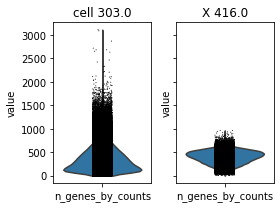

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(4, 3), tight_layout=True, sharey=True)

column = 'n_genes_by_counts'
sc.pl.violin(cell_adata, column, ax=axes[0], show=False)
axes[0].set_title(f'cell {cell_adata.obs[column].median()}')
sc.pl.violin(X_adata, column, ax=axes[1], show=False)
axes[1].set_title(f'X {X_adata.obs[column].median()}')

Text(0.5, 1.0, 'X 810.0')

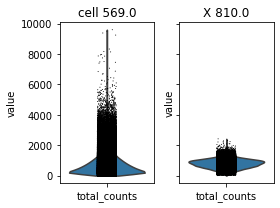

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(4, 3), tight_layout=True, sharey=True)

column = 'total_counts'
sc.pl.violin(cell_adata, column, ax=axes[0], show=False)
axes[0].set_title(f'cell {cell_adata.obs[column].median()}')
sc.pl.violin(X_adata, column, ax=axes[1], show=False)
axes[1].set_title(f'X {X_adata.obs[column].median()}')

### Cell-cell cosine distance

Cosine distance between each RNA-segmented cell and its (spatially) closest staining cell.

<AxesSubplot:xlabel='cosine_distance', ylabel='Count'>

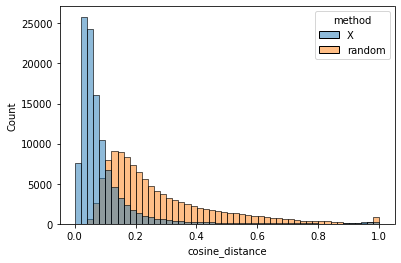

In [29]:
nearest = np.concatenate(list(metrics.pairwise_distances_chunked(X_adata.obsm['spatial'], cell_adata.obsm['spatial'], n_jobs=16, reduce_func=lambda D_chunk, start: D_chunk.argmin(axis=1), working_memory=64)))
cell = cell_adata.X.A
X = X_adata.X.A

X_distances = []
for i, j in enumerate(nearest):
    X_distances.append(spatial.distance.cosine(X[i], cell[j]))
    
random_distances = []
for i, j in enumerate(np.random.choice(cell_adata.n_obs, X_adata.n_obs, replace=False)):
    random_distances.append(spatial.distance.cosine(X[i], cell[j]))

sns.histplot(data=pd.concat((
    pd.DataFrame({'cosine_distance': X_distances, 'method': 'X'}),
    pd.DataFrame({'cosine_distance': random_distances, 'method': 'random'}),
), ignore_index=True), x='cosine_distance', hue='method', bins=50)